In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from glob import glob
from configs import *
from tqdm import tqdm
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from dataset import *
from time import time
tqdm.monitor_interval = 0
import torch
import torch.nn as nn
import numpy as np
torch.manual_seed(0)
np.random.seed(0)

In [3]:
FORECAST = 5
LAG = 12
EPS = 120
DEEP = True
SROUTE = SAMPLE_ROUTES[0]
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

In [4]:
dset = LocalRoute(SROUTE, 'train', 32, lag=LAG).generator()
evalset = LocalRoute(SROUTE, 'test', 32, lag=LAG).generator()

Locals dataset: train
 [*] Loaded routes: 1 (0.22s)
 [*] Has trainable inds: 262262
 [*] Subset train: 212106
Locals dataset: test
 [*] Loaded routes: 1 (0.23s)
 [*] Has trainable inds: 262262
 [*] Subset test: 50156


In [24]:
from models.Conv import Conv

In [25]:
model = Conv(forecast=FORECAST, hidden_size=256, lag=LAG).to(device)
model.device = device

In [26]:
criterion, opt, sch = model.params(lr=0.001)

In [27]:
evaluate(evalset, model, criterion)

AttributeError: 'Conv' object has no attribute 'conv_s'

In [9]:
losses = []
eval_losses = []
for eii  in range(EPS):
    for bii, batch in enumerate(dset):
        model.train()
        Xs, Ys = model.format_batch(batch)
        outputs = model(Xs)

        opt.zero_grad()
        loss = criterion(outputs, Ys)
        loss.backward()
        losses.append(loss.item())
        opt.step()

        sys.stdout.write('[%d/%d : %d/%d] - L%.2f      \r' % (
            eii+1, EPS,
            bii+1, len(dset), 
            loss.item()
        ))
    sys.stdout.write('\n')

    eval_losses.append(evaluate(evalset, model, criterion, result=True))
#     torch.save(model.state_dict(), 'checkpoints/%s_e%d.pth' % (model.name, eii+1))
    sys.stdout.flush()
    sch.step()

[1/120 : 6629/6629] - L0.50        
Eval loss: 4.960777336408441
[2/120 : 6629/6629] - L3.50        
Eval loss: 4.789549851923117
[3/120 : 6629/6629] - L3.22        
Eval loss: 4.037093617592235
[4/120 : 6629/6629] - L1.88        
Eval loss: 4.088412042992304
[5/120 : 6629/6629] - L1.34        
Eval loss: 3.9471318546910674
[6/120 : 6629/6629] - L0.69        
Eval loss: 4.483199656009674
[7/120 : 6629/6629] - L0.76        
Eval loss: 4.449333792343279
[8/120 : 6629/6629] - L1.60        
Eval loss: 4.651806777647259
[9/120 : 6629/6629] - L1.06        
Eval loss: 4.12395790135678
[10/120 : 6629/6629] - L0.71        
Eval loss: 3.7523480832994895
[11/120 : 6629/6629] - L0.59        
Eval loss: 3.816376940233215
[12/120 : 6629/6629] - L1.25        
Eval loss: 3.7442173882368572
[13/120 : 6629/6629] - L2.21        
Eval loss: 9.718362712358333
[14/120 : 6629/6629] - L95.32       
Eval loss: 10.575914274064862
[15/120 : 6629/6629] - L0.72        
Eval loss:1568 L1.07       4.042909417643535


Process Process-332:
Process Process-335:
Process Process-331:
Process Process-336:
Process Process-334:
Process Process-333:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _

KeyboardInterrupt: 

KeyboardInterrupt


In [10]:
# torch.save(model.state_dict(), 'checkpoints/tmp_local_rnn_deep.pth')

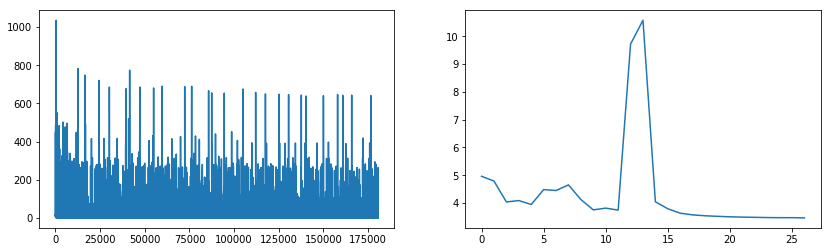

In [11]:
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.subplot(1, 2, 2)
plt.plot(eval_losses)
plt.show();plt.close()

4


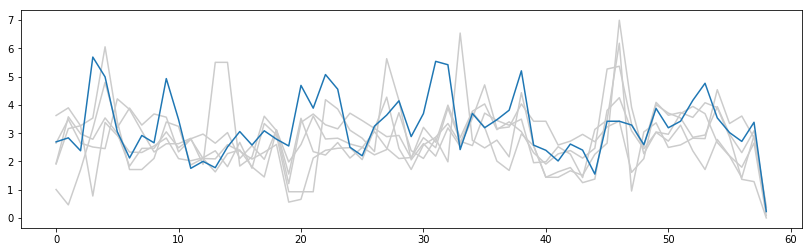

In [12]:
data = history_byname(SROUTE)

sample = data[int(TSTEPS*0.8):]
inds, integs = high_integ(sample[LAG:])
inds += LAG
# print(inds[0])
sample = sample[inds[0]-LAG:inds[0]]
# sample = hist_smooth(sample)
print(np.count_nonzero(np.isnan(sample)))
for jj, ii in zip(*np.where(np.isnan(sample))):
    sample[jj, ii] = sample[jj-1, ii]
show_context(sample)

In [13]:
preds = []
for bi in range(10, sample.shape[1]+1):
    hist = torch.Tensor(np.expand_dims(sample[:, bi-10:bi], 0))
    Xs, _ = model.format_batch(hist)
    yout = model(Xs)
    preds.append(tonpy(yout))

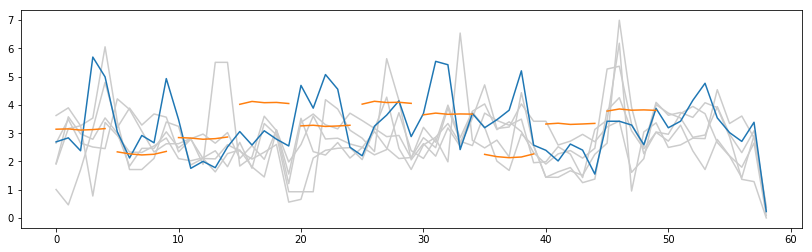

In [14]:
show_context(sample, draw=False)
for bi in range(10, sample.shape[1]+1, 5):
    ylast = np.flip(preds[bi-10][0, :])
    xpos = list(range(bi-10, bi-5))
    plt.plot(xpos, ylast, color='C1')
plt.show(); plt.close()